# Simulations

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as ss
import math
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import sklearn.mixture as mix
import tqdm
import datetime as dt

import mypack.plot as plot
import mypack.calc as calc
import mypack.clas as clas
import mypack.data as data

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set() # sets matplotlib style
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Inputs

#### Components

In [6]:
mus = [1+0.00075, 1-0.0015]
sigmas = [0.005, 0.02]

In [7]:
mu_0 = -0.001088091030590657
mu_1 = 0.0007135045295192978
sigma2_0 = 0.00035580049937316557
sigma2_1 = 3.712493137298489e-05
sigma_0 = sigma2_0**0.5
sigma_1 = sigma2_1**0.5

mus = [mu_0+1, mu_1+1]
sigmas = [sigma_0, sigma_1]

#### Markov Chain

In [8]:
p00 = 0.9578343472909316
p10 = 0.013033813102422378

transition_matrix = [[p00, 1-p00],
                     [p10, 1-p10]]

#initial_state = [0.2307254232726817,0.7692745767273184]

In [9]:
state_names = ['SS','S0','S1']

## Model Predictions

### Theoretical Predictions

In [10]:
T = 252
df_calc = pd.DataFrame(index=range(0,T+1), columns=pd.MultiIndex.from_product([state_names,['p0','p1','m','v','s','k','cm','cv','cs','ck']]))

In [11]:
steady_state = calc.calculate_steady_state_probabilities(transition_matrix)

i = 0
for iState in state_names:
    
    initial_state = [steady_state,[1,0],[0,1]][i]
    
    expected_states = []
    for iPer in range(0,T+1):
        expected_states += [calc.iterate_markov_chain(initial_state,transition_matrix,iPer)]
    
    factors = clas.ProductDistribution([])
    product_moments = []
    t = 0
    for p_t in tqdm.tqdm(expected_states):
        # set up period's mixture distribution
        mixture = clas.MixtureDistribution([])
        for (m,s,p) in zip(mus,sigmas,p_t):
            mixture.add_component((m,s,p))
    
        # calculate moments
        (m,v,s,k) = mixture.mvsk()
        moments = (m, v, s*v**1.5, (k+3)*v**2)
        if t > 0:
            factors.add_factor(moments)
    
        # store
        df_calc.loc[t,(iState,['p0','p1'])] = p_t
        df_calc.loc[t,(iState,['m','v','s','k'])] = [m,v,s,k]
        if t > 0:
            df_calc.loc[t,(iState,['cm','cv','cs','ck'])] = factors.mvsk()
        
        t += 1
    
    df_calc[(iState,'m')] = df_calc[(iState,'m')]-1
    df_calc[(iState,'cm')] = df_calc[(iState,'cm')]-1
    
    i += 1

100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:03<00:00, 69.97it/s]


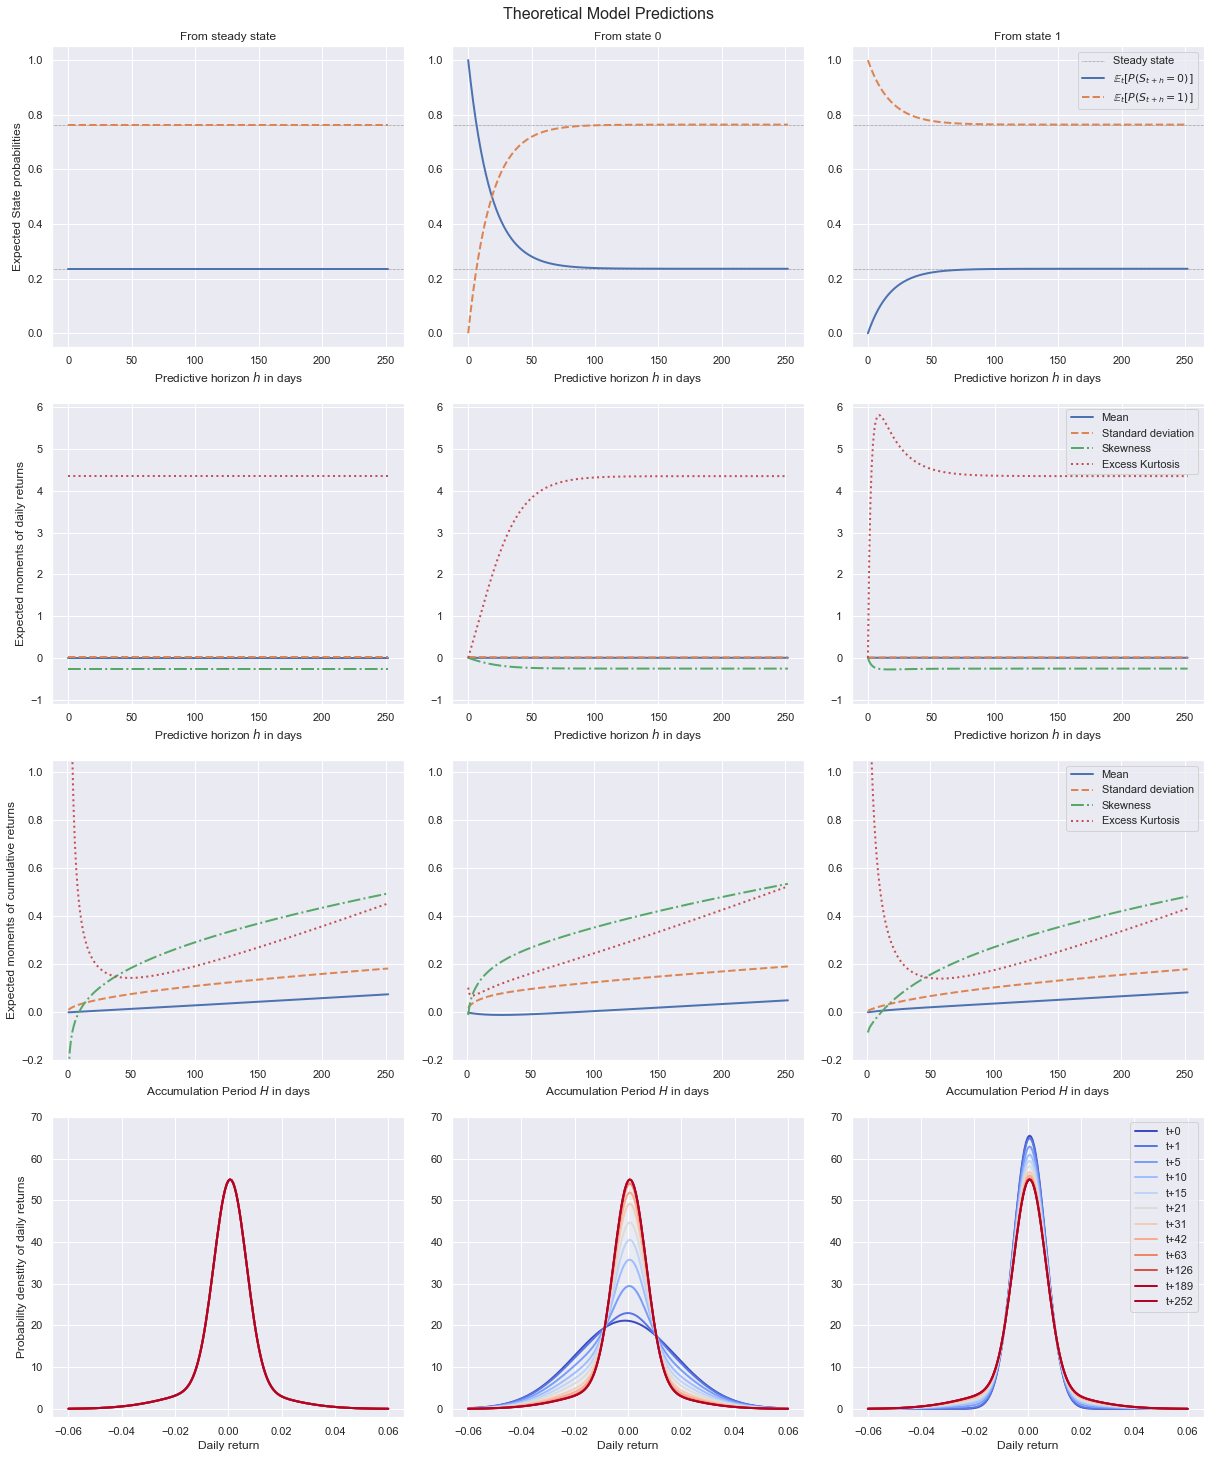

In [12]:
fig, axes = plt.subplots(4, 3, figsize=[17,20])
colormap = plt.cm.get_cmap('coolwarm')

i = 0
for iState in state_names:
    axes[0,i].set_ylim([-0.05,1.05])
    axes[0,i].axhline(steady_state[0], color='k', linewidth=0.5, linestyle=':', label='Steady state')
    axes[0,i].axhline(steady_state[1], color='k', linewidth=0.5, linestyle=':')
    axes[0,i].plot(df_calc[(iState,'p0')], linewidth=2, linestyle='-', label='$\mathbb{E}_t[P(S_{t+h}=0)]$')
    axes[0,i].plot(df_calc[(iState,'p1')], linewidth=2, linestyle='--', label='$\mathbb{E}_t[P(S_{t+h}=1)]$')
    axes[0,i].set_xlabel('Predictive horizon $h$ in days')
    
    axes[1,i].set_ylim([-1.1,6.1])
    axes[1,i].plot(df_calc[(iState,'m')], linewidth=2, linestyle='-', label='Mean')
    axes[1,i].plot(df_calc[(iState,'v')]**0.5, linewidth=2, linestyle='--', label='Standard deviation')
    axes[1,i].plot(df_calc[(iState,'s')], linewidth=2, linestyle='-.', label='Skewness')
    axes[1,i].plot(df_calc[(iState,'k')], linewidth=2, linestyle=':', label='Excess Kurtosis')
    axes[1,i].set_xlabel('Predictive horizon $h$ in days')
    
    axes[2,i].set_ylim([-0.2,1.05])
    axes[2,i].plot(df_calc[(iState,'cm')], linewidth=2, linestyle='-', label='Mean')
    axes[2,i].plot(df_calc[(iState,'cv')]**0.5, linewidth=2, linestyle='--', label='Standard deviation')
    axes[2,i].plot(df_calc[(iState,'cs')], linewidth=2, linestyle='-.', label='Skewness')
    axes[2,i].plot(df_calc[(iState,'ck')], linewidth=2, linestyle=':', label='Excess Kurtosis')
    axes[2,i].set_xlabel('Accumulation Period $H$ in days')
    
    h = 0
    for iHorizon in [0,1,5,10,15,21,31,42,63,126,189,252]:
        mixture = clas.MixtureDistribution([])
        mixture.add_component((mus[0]-1,sigmas[0],df_calc[(iState,'p0')].loc[iHorizon]))
        mixture.add_component((mus[1]-1,sigmas[1],df_calc[(iState,'p1')].loc[iHorizon]))
        x = np.linspace(-0.06,0.06,201)
        y = mixture.pdf(x)
        axes[3,i].set_ylim([-2,70])
        axes[3,i].plot(x, y, color=colormap(1/10*h), label='t+'+str(iHorizon), linewidth=2)
        axes[3,i].set_xlabel('Daily return')
        
        h +=1
        
    i += 1
    
axes[0,0].set_ylabel('Expected State probabilities')
axes[1,0].set_ylabel('Expected moments of daily returns')
axes[2,0].set_ylabel('Expected moments of cumulative returns')
axes[3,0].set_ylabel('Probability denstity of daily returns')

axes[0,0].set_title('From steady state')
axes[0,1].set_title('From state 0')
axes[0,2].set_title('From state 1')

axes[0,2].legend()
axes[1,2].legend()
axes[2,2].legend()
axes[3,2].legend()

fig.suptitle('Theoretical Model Predictions', y=1.01, fontsize=16)

fig.tight_layout()

plt.show()

#fig.savefig('theoreticalPredictionsPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

### Monte Carlo Simulation: Reduced distribution

In [13]:
T =252
N = 100000
df_sample = pd.DataFrame(index=list(range(1,T+1)), columns=pd.MultiIndex.from_product([state_names,list(range(0,N))]),dtype='float64')

In [14]:
steady_state = calc.calculate_steady_state_probabilities(transition_matrix)

i = 0
for iState in state_names:
    
    initial_state = [steady_state,[1,0],[0,1]][i]
    state_returns = np.ndarray((0,N))
    expected_states = []
    
    for iPer in tqdm.trange(1,T+1):
        expected_states += [calc.iterate_markov_chain(initial_state,transition_matrix,iPer)]
        mix_params = [(m,s,p) for (m,s,p) in zip(mus,sigmas,expected_states[iPer-1])]
        
        mixture_distribution = clas.MixtureDistribution(mix_params)
        return_draw = mixture_distribution.rvs(N)
        return_draw.shape = (1,N)
        
        state_returns = np.concatenate((state_returns,return_draw), axis=0)
        
        #df_sample.loc[iPer,iState] = return_draw
    df_sample[iState] = state_returns
    
    i += 1
    
df_cumulative = df_sample.cumprod()-1

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [13:33<00:00,  3.25s/it]


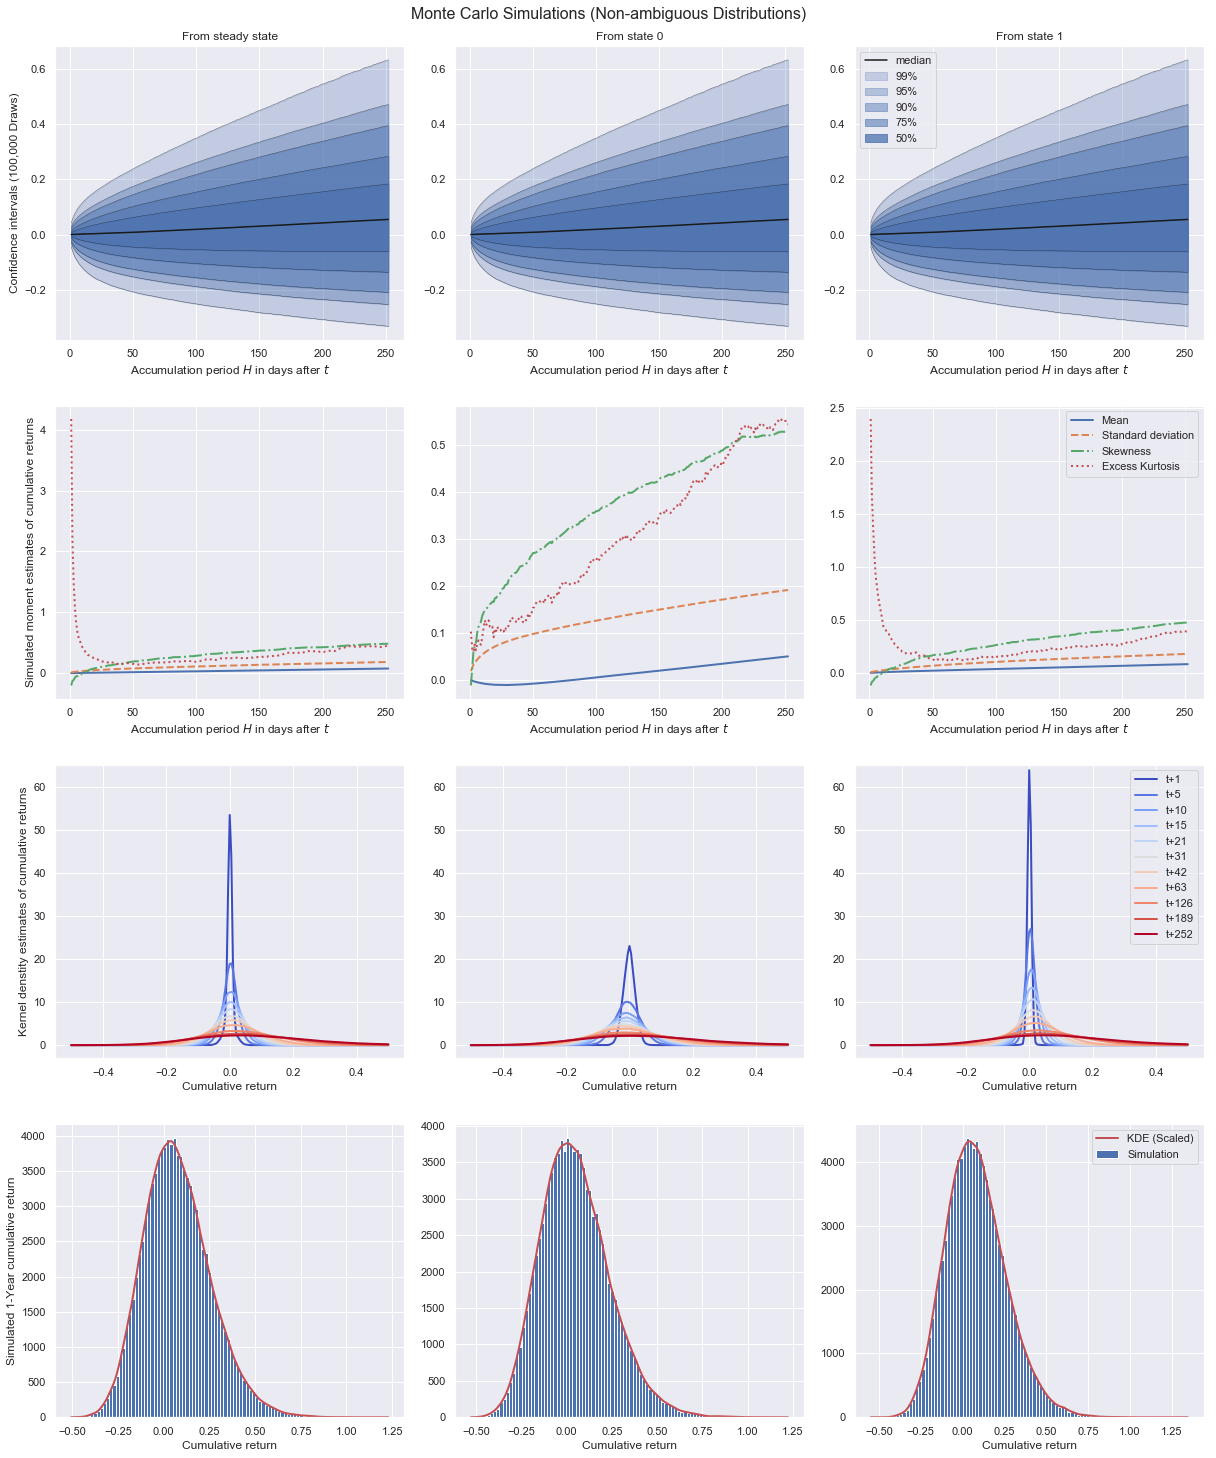

In [15]:
fig, axes = plt.subplots(4, 3, figsize=[17,20])
colormap = plt.cm.get_cmap('coolwarm')

i = 0
for iState in state_names:
    l = 0
    
    #axes[l,i].plot(df_cumulative[iState].loc[:,0:50], linewidth=1, linestyle='-', rasterized=True)
    #axes[l,i].set_xlabel('Accumulation period $H$ in days after $t$')
    # l += 1
    
    quantiles = df_cumulative.quantile([0.005,0.025,0.05,0.125,0.25,0.5,0.75,0.875,0.95,0.975,0.995], axis=1).T
    axes[l,i].fill_between(quantiles.index, quantiles[0.005], quantiles[0.995], linewidth=1, color='b', alpha=0.25, label='99%')
    axes[l,i].fill_between(quantiles.index, quantiles[0.025], quantiles[0.975], linewidth=1, color='b', alpha=0.35, label='95%')
    axes[l,i].fill_between(quantiles.index, quantiles[0.05], quantiles[0.95], linewidth=1, color='b', alpha=0.45, label='90%')
    axes[l,i].fill_between(quantiles.index, quantiles[0.125], quantiles[0.875], linewidth=1, color='b', alpha=0.55, label='75%')
    axes[l,i].fill_between(quantiles.index, quantiles[0.25], quantiles[0.75], linewidth=1, color='b', alpha=0.75, label='50%')
    axes[l,i].plot(quantiles.index, quantiles, color='k', linewidth=0.3)
    axes[l,i].plot(quantiles.index, quantiles[0.5], label='median', color='k')
    axes[l,i].set_xlabel('Accumulation period $H$ in days after $t$')
    l += 1
    
    #axes[l,i].set_ylim([-0.2,1.05])
    axes[l,i].plot(df_cumulative[iState].T.mean(), linewidth=2, linestyle='-', label='Mean')
    axes[l,i].plot(df_cumulative[iState].T.std(), linewidth=2, linestyle='--', label='Standard deviation')
    axes[l,i].plot(df_cumulative[iState].T.skew(), linewidth=2, linestyle='-.', label='Skewness')
    axes[l,i].plot(df_cumulative[iState].T.kurt(), linewidth=2, linestyle=':', label='Excess Kurtosis')
    axes[l,i].set_xlabel('Accumulation period $H$ in days after $t$')
    l += 1
    
    h = 0
    for iHorizon in [1,5,10,15,21,31,42,63,126,189,252]:
        kerneldensity  = sp.stats.gaussian_kde(df_cumulative.loc[iHorizon,:][iState])
        x = np.linspace(-0.5,0.5,201)
        y = kerneldensity(x)
        axes[l,i].set_ylim([-3,65])
        axes[l,i].plot(x, y, color=colormap(1/10*h), label='t+'+str(iHorizon), linewidth=2)
        axes[l,i].set_xlabel('Cumulative return')
        
        h +=1
    l += 1
        
    hist = axes[l,i].hist(df_cumulative.loc[iHorizon,:][iState], bins=100, label='Simulation')#, histtype='stepfilled', )
    x = np.linspace(df_cumulative.loc[iHorizon,:][iState].min(),df_cumulative.loc[iHorizon,:][iState].max(),201)
    y = kerneldensity(x)
    scale = N/100*(hist[1].max()-hist[1].min())
    axes[l,i].plot(x, scale*y, linewidth=2, color='r', label='KDE (Scaled)')
    axes[l,i].set_xlabel('Cumulative return')
        
    i += 1

axes[0,0].set_title('From steady state')
axes[0,1].set_title('From state 0')
axes[0,2].set_title('From state 1')

l = 0
#axes[l,0].set_ylabel('50 Monte Carlo sample paths')
#l += 1

axes[l,0].set_ylabel('Confidence intervals (100,000 Draws)')
axes[l,2].legend(loc='upper left')
l += 1

axes[l,0].set_ylabel('Simulated moment estimates of cumulative returns')
axes[l,2].legend()
l += 1

axes[l,0].set_ylabel('Kernel denstity estimates of cumulative returns')
axes[l,2].legend()
l += 1

axes[l,0].set_ylabel('Simulated 1-Year cumulative return')
axes[l,2].legend()

fig.suptitle('Monte Carlo Simulations (Non-ambiguous Distributions)', y=1.01, fontsize=16)

fig.tight_layout()

plt.show()

fig.savefig('reducedMonteCarloPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [16]:
calc.calculate_columnwise_autocorrelation(df_sample).groupby(level=0).mean()

S0   -0.0036
S1   -0.0038
SS   -0.0037
dtype: float64

### Monte Carlo Simulation: Ambiguous draws

In [18]:
T =252
N = 100000
df_sample = pd.DataFrame(index=list(range(1,T+1)), columns=pd.MultiIndex.from_product([state_names,list(range(0,N))]),dtype='float64')

In [19]:
steady_state = calc.calculate_steady_state_probabilities(transition_matrix)
norm_params = [(m,s) for (m,s) in zip(mus,sigmas)]

i = 0
for iState in state_names:
    
    initial_state = [steady_state,[1,0],[0,1]][i]
    markov_chain = clas.MarkovChain(transition_matrix,initial_state)
    
    for iDraw in tqdm.trange(0,N):
        markov_draw = markov_chain.rvs(T)        
        return_draw = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in markov_draw),dtype=np.float64)
        
        df_sample[(iState,iDraw)] = return_draw
    
    i += 1
    
df_cumulative = df_sample.cumprod()-1

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [39:09<00:00, 42.57it/s]


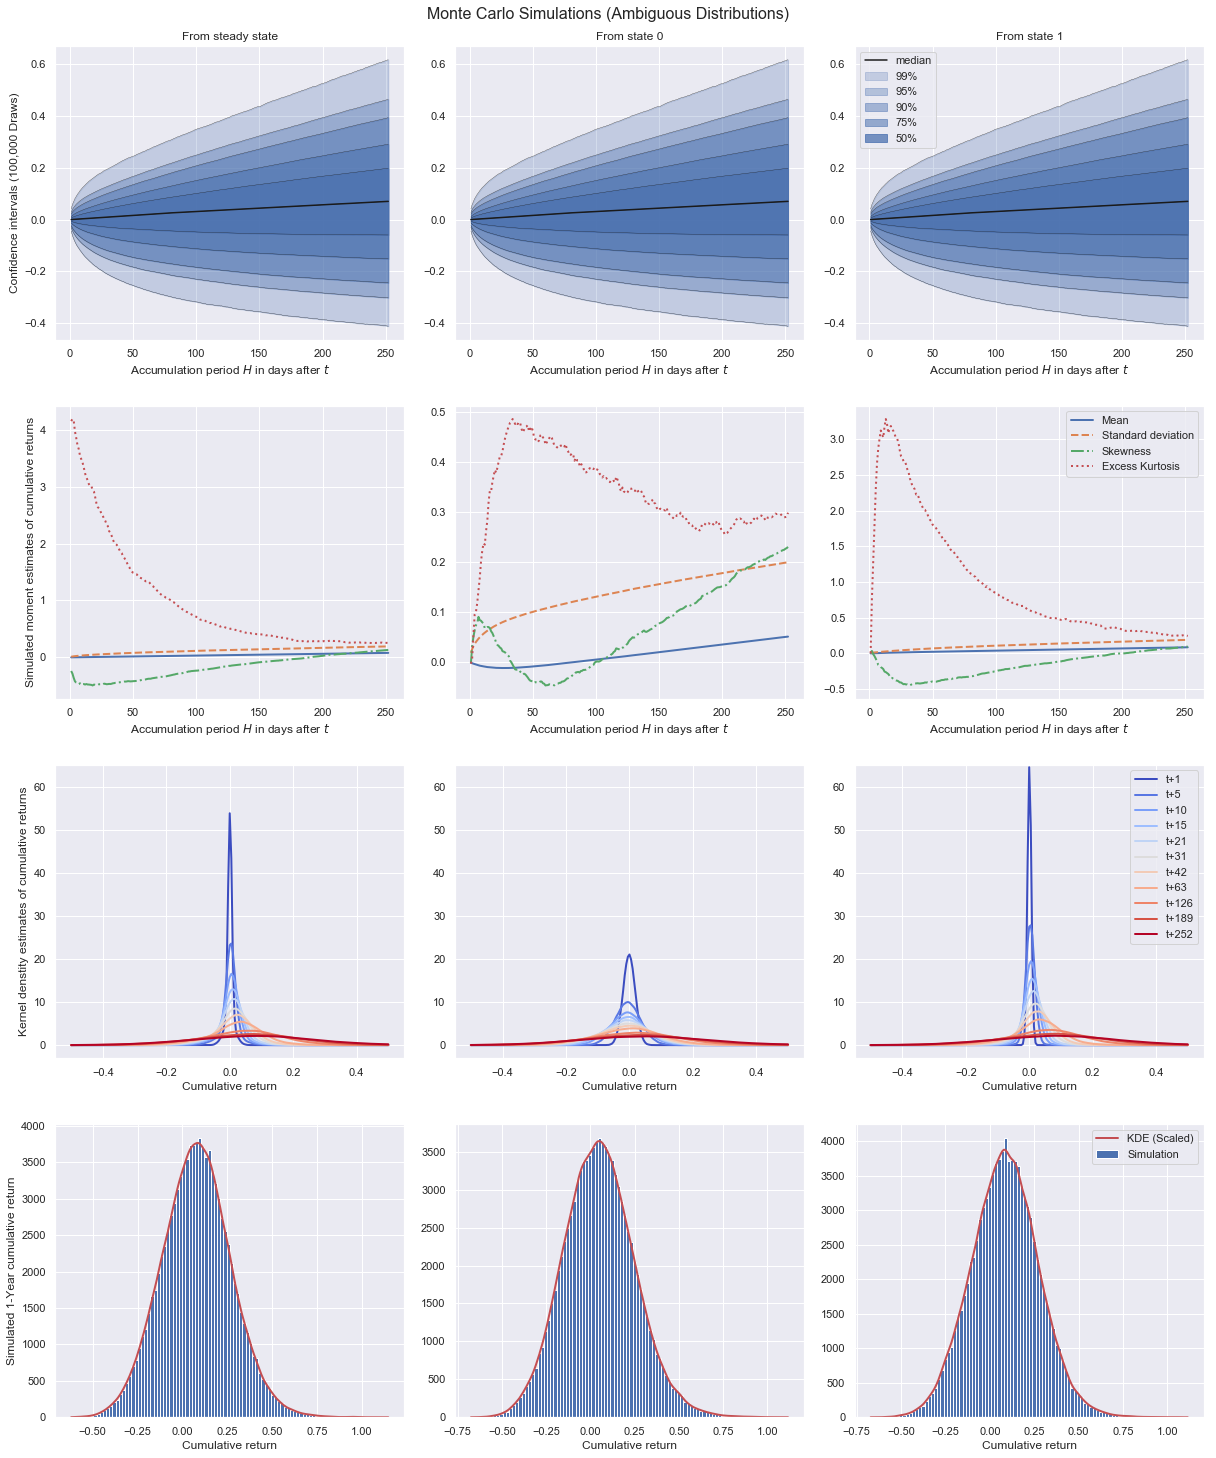

In [20]:
fig, axes = plt.subplots(4, 3, figsize=[17,20])
colormap = plt.cm.get_cmap('coolwarm')

i = 0
for iState in state_names:
    l = 0
    
    #axes[l,i].plot(df_cumulative[iState].loc[:,0:50], linewidth=1, linestyle='-', rasterized=True)
    #axes[l,i].set_xlabel('Accumulation period $H$ in days after $t$')
    # l += 1
    
    quantiles = df_cumulative.quantile([0.005,0.025,0.05,0.125,0.25,0.5,0.75,0.875,0.95,0.975,0.995], axis=1).T
    axes[l,i].fill_between(quantiles.index, quantiles[0.005], quantiles[0.995], linewidth=1, color='b', alpha=0.25, label='99%')
    axes[l,i].fill_between(quantiles.index, quantiles[0.025], quantiles[0.975], linewidth=1, color='b', alpha=0.35, label='95%')
    axes[l,i].fill_between(quantiles.index, quantiles[0.05], quantiles[0.95], linewidth=1, color='b', alpha=0.45, label='90%')
    axes[l,i].fill_between(quantiles.index, quantiles[0.125], quantiles[0.875], linewidth=1, color='b', alpha=0.55, label='75%')
    axes[l,i].fill_between(quantiles.index, quantiles[0.25], quantiles[0.75], linewidth=1, color='b', alpha=0.75, label='50%')
    axes[l,i].plot(quantiles.index, quantiles, color='k', linewidth=0.3)
    axes[l,i].plot(quantiles.index, quantiles[0.5], label='median', color='k')
    axes[l,i].set_xlabel('Accumulation period $H$ in days after $t$')
    l += 1
    
    #axes[l,i].set_ylim([-0.2,1.05])
    axes[l,i].plot(df_cumulative[iState].T.mean(), linewidth=2, linestyle='-', label='Mean')
    axes[l,i].plot(df_cumulative[iState].T.std(), linewidth=2, linestyle='--', label='Standard deviation')
    axes[l,i].plot(df_cumulative[iState].T.skew(), linewidth=2, linestyle='-.', label='Skewness')
    axes[l,i].plot(df_cumulative[iState].T.kurt(), linewidth=2, linestyle=':', label='Excess Kurtosis')
    axes[l,i].set_xlabel('Accumulation period $H$ in days after $t$')
    l += 1
    
    h = 0
    for iHorizon in [1,5,10,15,21,31,42,63,126,189,252]:
        kerneldensity  = sp.stats.gaussian_kde(df_cumulative.loc[iHorizon,:][iState])
        x = np.linspace(-0.5,0.5,201)
        y = kerneldensity(x)
        axes[l,i].set_ylim([-3,65])
        axes[l,i].plot(x, y, color=colormap(1/10*h), label='t+'+str(iHorizon), linewidth=2)
        axes[l,i].set_xlabel('Cumulative return')
        
        h +=1
    l += 1
        
    hist = axes[l,i].hist(df_cumulative.loc[iHorizon,:][iState], bins=100, label='Simulation')#, histtype='stepfilled', )
    x = np.linspace(df_cumulative.loc[iHorizon,:][iState].min(),df_cumulative.loc[iHorizon,:][iState].max(),201)
    y = kerneldensity(x)
    scale = N/100*(hist[1].max()-hist[1].min())
    axes[l,i].plot(x, scale*y, linewidth=2, color='r', label='KDE (Scaled)')
    axes[l,i].set_xlabel('Cumulative return')
        
    i += 1

axes[0,0].set_title('From steady state')
axes[0,1].set_title('From state 0')
axes[0,2].set_title('From state 1')

l = 0
#axes[l,0].set_ylabel('50 Monte Carlo sample paths')
#l += 1

axes[l,0].set_ylabel('Confidence intervals (100,000 Draws)')
axes[l,2].legend(loc='upper left')
l += 1

axes[l,0].set_ylabel('Simulated moment estimates of cumulative returns')
axes[l,2].legend()
l += 1

axes[l,0].set_ylabel('Kernel denstity estimates of cumulative returns')
axes[l,2].legend()
l += 1

axes[l,0].set_ylabel('Simulated 1-Year cumulative return')
axes[l,2].legend()

fig.suptitle('Monte Carlo Simulations (Ambiguous Distributions)', y=1.01, fontsize=16)

fig.tight_layout()

plt.show()

fig.savefig('switchingMonteCarloPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [21]:
calc.calculate_columnwise_autocorrelation(df_sample).groupby(level=0).mean()

S0    0.0005
S1   -0.0004
SS    0.0002
dtype: float64

## Data Moments

Data is imported from [Kenneth French's data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and [FRED](https://fred.stlouisfed.org/series/). Currently, this workbook uses 49 industry portfolios and the FF3 factors. Additionally, NBER recession indicators complement the data.

In [22]:
#sample_start = dt.datetime(1962,1,1)
sample_start = dt.datetime(1900,1,1)
sample_end = dt.datetime(2019,5,31)

In [23]:
factors_daily = data.download_factor_data('D')/100
factors_daily = factors_daily.loc[(factors_daily.index >= sample_start) & (factors_daily.index <= sample_end)]

In [29]:
# set up destination frame
df_market_returns = factors_daily['Mkt-RF'].to_frame()

### Aggregate

In [30]:
T = 252

In [31]:
for h in tqdm.trange(1,T+1):
    df_market_returns[h] = df_market_returns['Mkt-RF'].rolling(h).apply(lambda x: np.prod(1 + x) - 1, raw=True)

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [01:13<00:00,  3.25it/s]


In [32]:
df_market_returns = df_market_returns.drop(columns=['Mkt-RF'])

### Overlapping samples

In [33]:
df_market_moments = pd.DataFrame(index=df_market_returns.columns, columns=['mean','std','skew','kurt'])
df_market_moments['mean'] = df_market_returns.mean()
df_market_moments['std'] = df_market_returns.std()
df_market_moments['skew'] = df_market_returns.skew()
df_market_moments['kurt'] = df_market_returns.kurt()

### Non-Overlapping samples

In [49]:
df_market_moments_nonoverlapping = pd.DataFrame(index=df_market_returns.columns, columns=['mean','std','skew','kurt'])

for h in tqdm.trange(1,T):
    nonoveralpping_sample = df_market_returns.iloc[h-1::h, h-1]
    df_market_moments_nonoverlapping.loc[h,'mean'] = nonoveralpping_sample.mean()
    df_market_moments_nonoverlapping.loc[h,'std'] = nonoveralpping_sample.std()
    df_market_moments_nonoverlapping.loc[h,'skew'] = nonoveralpping_sample.skew()
    df_market_moments_nonoverlapping.loc[h,'kurt'] = nonoveralpping_sample.kurt()

100%|███████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 254.81it/s]


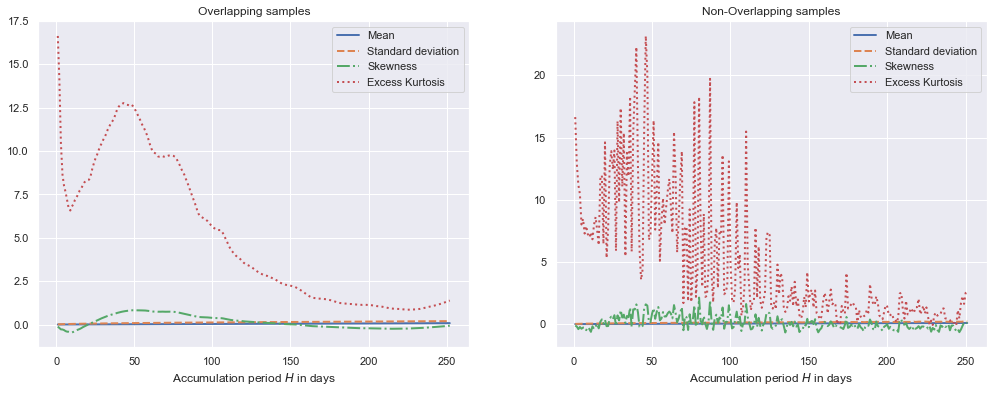

In [52]:
#plot
fig,axes = plt.subplots(1,2,figsize=[17,6])

axes[0].plot(df_market_returns.mean(), linewidth=2, linestyle='-', label='Mean')
axes[0].plot(df_market_returns.std(), linewidth=2, linestyle='--', label='Standard deviation')
axes[0].plot(df_market_returns.skew(), linewidth=2, linestyle='-.', label='Skewness')
axes[0].plot(df_market_returns.kurt(), linewidth=2, linestyle=':', label='Excess Kurtosis')

axes[0].set_xlabel('Accumulation period $H$ in days')
axes[0].set_title('Overlapping samples')
axes[0].legend(loc='upper right')

axes[1].plot(df_market_moments_nonoverlapping['mean'], linewidth=2, linestyle='-', label='Mean')
axes[1].plot(df_market_moments_nonoverlapping['std'], linewidth=2, linestyle='--', label='Standard deviation')
axes[1].plot(df_market_moments_nonoverlapping['skew'], linewidth=2, linestyle='-.', label='Skewness')
axes[1].plot(df_market_moments_nonoverlapping['kurt'], linewidth=2, linestyle=':', label='Excess Kurtosis')

axes[1].set_xlabel('Accumulation period $H$ in days')
axes[1].set_title('Non-Overlapping samples')
axes[1].legend(loc='upper right')

plt.show()

fig.savefig('dataMomentsPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')